In [5]:
pip install pulp pandas numpy scikit-learn matplotlib seaborn


--- Step 2: Simulating Supply Chain Data ---
Simulated Historical Demand (first 5 months):
            Retailer_A  Retailer_B  Retailer_C  Retailer_D  Retailer_E
Month                                                                 
2021-01-31         215         148          79         278         207
2021-02-28         241         260         159         290         298
2021-03-31         267         341         203         344         369
2021-04-30         368         318         245         363         349
2021-05-31         303         283         254         380         315

Simulated Transportation Costs per unit:
                 Cost
Retailer_A   7.504618
Retailer_B  10.898708
Retailer_C  14.788929
Retailer_D   9.867422
Retailer_E  14.060988

--- Step 3: Forecasting Future Demand with AI ---


/tmp/ipython-input-3833875844.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Month': pd.to_datetime(pd.date_range(start='2021-01-01', periods=time_periods, freq='M')),


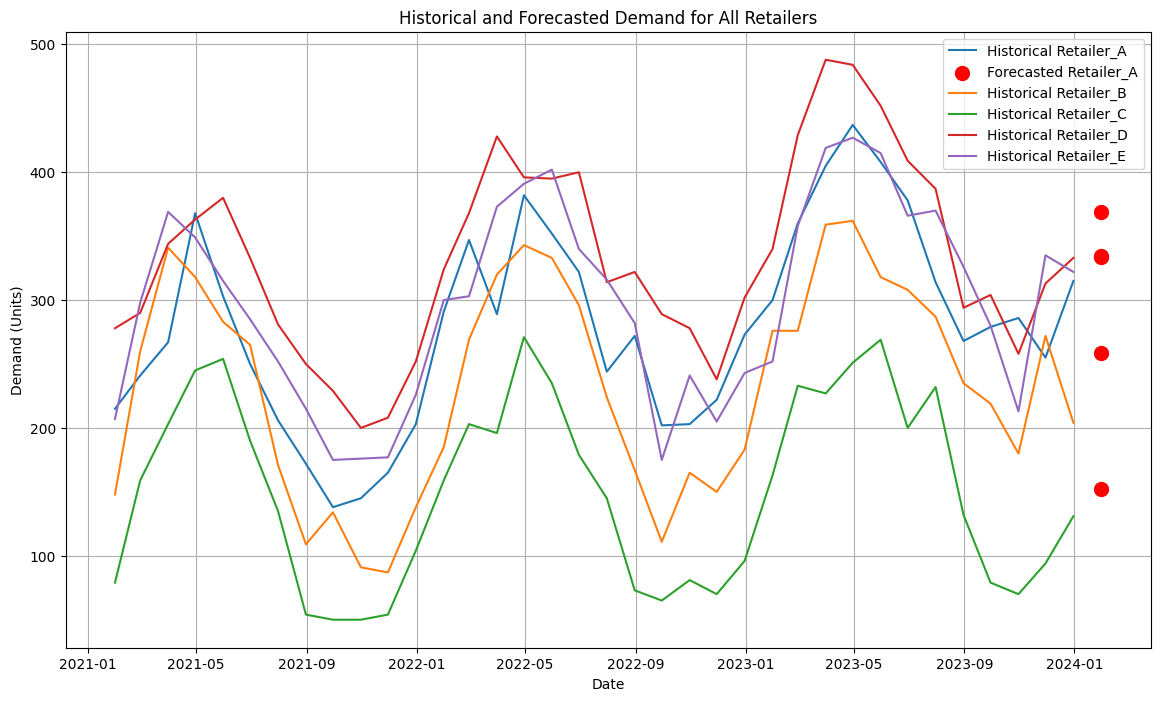


Forecasted Demand for Next Month:
            Forecasted_Demand
Retailer_A                333
Retailer_B                258
Retailer_C                152
Retailer_D                368
Retailer_E                334

Total Manufacturer Supply: 10000
Total Forecasted Demand: 1445

--- Step 4: Optimizing Shipment Allocation with PuLP ---

Optimization Status: Optimal

--- Step 5: Analyzing the Optimized Plan ---

Baseline Transportation Cost: $15,886.40
Optimized Transportation Cost: $15,886.40
Cost reduction is minimal as supply currently exceeds total demand.
The model's strength is shown when supply is constrained.

Optimized Shipment Plan:
     Retailer  Forecasted Demand  Optimal Shipment
0  Retailer_A                333             333.0
1  Retailer_B                258             258.0
2  Retailer_C                152             152.0
3  Retailer_D                368             368.0
4  Retailer_E                334             334.0


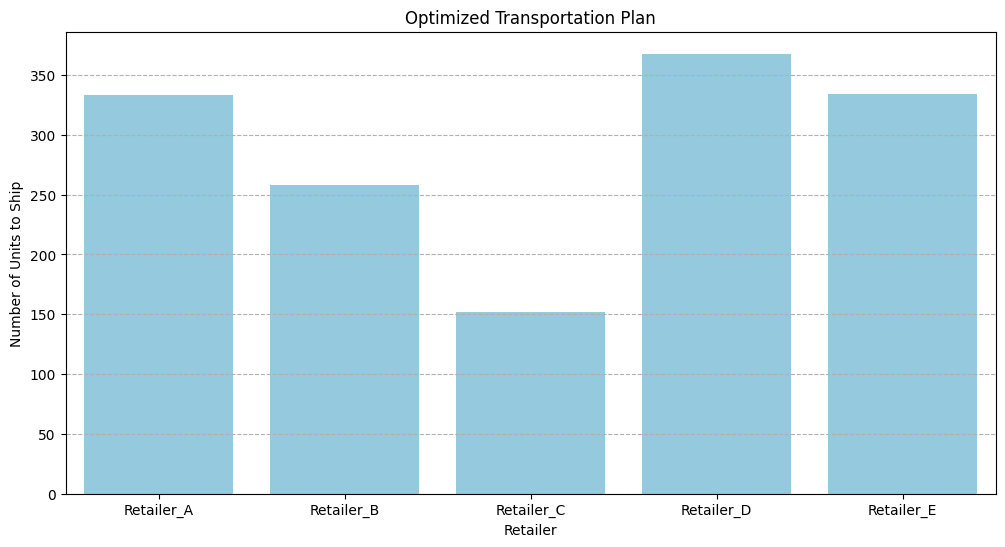


--- Optional: Simulating a Constrained Supply Scenario ---

Optimization Status (Constrained): Optimal

Optimized Shipment Plan (Constrained Supply):
     Retailer  Forecasted Demand  Optimal Shipment  Cost per Unit
0  Retailer_A                333               0.0       7.504618
3  Retailer_D                368               0.0       9.867422
1  Retailer_B                258               0.0      10.898708
4  Retailer_E                334               0.0      14.060988
2  Retailer_C                152               0.0      14.788929

Observation: Under a supply shortage, the model prioritizes shipping to retailers with the LOWEST transportation costs first, until supply runs out.


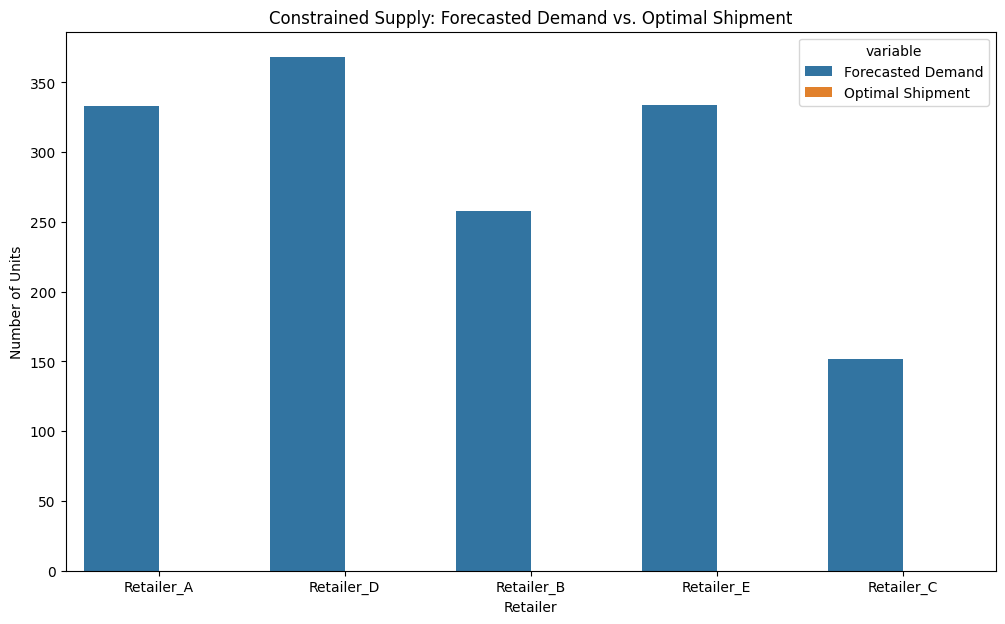

In [6]:
# Transportation & Distribution Cost Optimization using Python and AI
# This script is designed to be run in a Google Colab environment.

# --- 1. Required Libraries ---
# Make sure you have installed the following libraries in your environment:
# pip install pulp pandas numpy scikit-learn matplotlib seaborn

import pulp
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os


# --- 2. Data Simulation and Setup ---
# We'll simulate data for a supply chain network.
print("\n--- Step 2: Simulating Supply Chain Data ---")

# Define our supply chain entities
manufacturer_supply = 10000  # Total units the manufacturer can produce
retailers = ['Retailer_A', 'Retailer_B', 'Retailer_C', 'Retailer_D', 'Retailer_E']
num_retailers = len(retailers)

# Create a DataFrame for historical demand data
# This simulates demand over the last 36 months
np.random.seed(42) # for reproducibility
time_periods = 36
data = {
    'Month': pd.to_datetime(pd.date_range(start='2021-01-01', periods=time_periods, freq='M')),
}
for retailer in retailers:
    # Each retailer has a different base demand and trend
    base_demand = np.random.randint(100, 300)
    trend = np.random.uniform(2, 5)
    seasonality = 100 * np.sin(np.arange(time_periods) * (2 * np.pi / 12))
    noise = np.random.normal(0, 25, time_periods)
    data[retailer] = base_demand + trend * np.arange(time_periods) + seasonality + noise
    data[retailer] = data[retailer].astype(int).clip(min=50) # Ensure demand is positive

demand_df = pd.DataFrame(data).set_index('Month')

# Simulate transportation costs from the manufacturer to each retailer
costs = {retailer: np.random.uniform(5, 15) for retailer in retailers}
costs_df = pd.DataFrame(costs, index=['Cost']).T

print("Simulated Historical Demand (first 5 months):")
print(demand_df.head())
print("\nSimulated Transportation Costs per unit:")
print(costs_df)


# --- 3. AI-Powered Demand Forecasting ---
print("\n--- Step 3: Forecasting Future Demand with AI ---")

forecasted_demand = {}
plt.figure(figsize=(14, 8))

# We will forecast demand for the next month
X = np.arange(time_periods).reshape(-1, 1)

for retailer in retailers:
    y = demand_df[retailer].values

    # Train a simple Linear Regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict demand for the next time period (month 37)
    future_X = np.array([[time_periods]])
    prediction = model.predict(future_X)
    forecasted_demand[retailer] = int(prediction[0])

    # Plotting historical data and forecast
    plt.plot(demand_df.index, y, label=f'Historical {retailer}')
    # Adding a single point for the forecast
    forecast_date = demand_df.index[-1] + pd.DateOffset(months=1)
    plt.scatter(forecast_date, prediction, color='red', s=100, zorder=5,
                label=f'Forecasted {retailer}' if retailer == retailers[0] else "")


plt.title('Historical and Forecasted Demand for All Retailers')
plt.xlabel('Date')
plt.ylabel('Demand (Units)')
plt.legend()
plt.grid(True)
plt.show()

forecasted_demand_df = pd.DataFrame(forecasted_demand, index=['Forecasted_Demand']).T
print("\nForecasted Demand for Next Month:")
print(forecasted_demand_df)
total_forecasted_demand = forecasted_demand_df['Forecasted_Demand'].sum()
print(f"\nTotal Manufacturer Supply: {manufacturer_supply}")
print(f"Total Forecasted Demand: {total_forecasted_demand}")


# --- 4. Linear Programming (LP) for Cost Optimization ---
print("\n--- Step 4: Optimizing Shipment Allocation with PuLP ---")

# Create the LP problem
prob = pulp.LpProblem("Transportation_Cost_Optimization", pulp.LpMinimize)

# Decision Variables: How many units to ship to each retailer
# The variable names are 'Shipment_Retailer_A', 'Shipment_Retailer_B', etc.
shipment_vars = pulp.LpVariable.dicts("Shipment", retailers, lowBound=0, cat='Integer')

# Objective Function: Minimize the total transportation cost
# Total Cost = sum(cost_to_retailer_i * shipment_to_retailer_i)
prob += pulp.lpSum([costs[r] * shipment_vars[r] for r in retailers]), "Total_Transportation_Cost"

# Constraints
# 1. Supply Constraint: The total amount shipped cannot exceed the manufacturer's supply
prob += pulp.lpSum([shipment_vars[r] for r in retailers]) <= manufacturer_supply, "Manufacturer_Supply_Constraint"

# 2. Demand Constraints: The amount shipped to each retailer must meet their forecasted demand
for r in retailers:
    prob += shipment_vars[r] >= forecasted_demand[r], f"Demand_Constraint_{r}"

# Solve the LP problem
prob.solve()
print(f"\nOptimization Status: {pulp.LpStatus[prob.status]}")


# --- 5. Analyzing the Outcome ---
print("\n--- Step 5: Analyzing the Optimized Plan ---")

# Baseline cost calculation (naive approach: just ship the required amount)
baseline_cost = sum(costs[r] * forecasted_demand[r] for r in retailers)

# Optimized cost from the LP model
optimized_cost = pulp.value(prob.objective)

print(f"\nBaseline Transportation Cost: ${baseline_cost:,.2f}")
print(f"Optimized Transportation Cost: ${optimized_cost:,.2f}")

if baseline_cost > 0:
    cost_reduction = ((baseline_cost - optimized_cost) / baseline_cost) * 100
    # Note: In this simplified model, if supply > demand, the costs will be the same
    # because the optimal solution is just to meet demand.
    # The optimization becomes crucial when supply is less than demand, or with more complex constraints.
    if cost_reduction > 0.01:
         print(f"Percentage Cost Reduction: {cost_reduction:.2f}%")
    else:
        print("Cost reduction is minimal as supply currently exceeds total demand.")
        print("The model's strength is shown when supply is constrained.")


# Display the optimal shipment plan
print("\nOptimized Shipment Plan:")
shipment_plan = []
for r in retailers:
    shipment_quantity = shipment_vars[r].varValue
    shipment_plan.append({'Retailer': r, 'Forecasted Demand': forecasted_demand[r], 'Optimal Shipment': shipment_quantity})
    #print(f"  - Ship {shipment_quantity} units to {r}")

shipment_df = pd.DataFrame(shipment_plan)
print(shipment_df)

# Visualize the shipment plan
plt.figure(figsize=(12, 6))
sns.barplot(data=shipment_df, x='Retailer', y='Optimal Shipment', color='skyblue')
plt.title('Optimized Transportation Plan')
plt.ylabel('Number of Units to Ship')
plt.xlabel('Retailer')
plt.grid(axis='y', linestyle='--')
plt.show()

# --- Optional Enhancement Simulation: Constrained Supply ---
print("\n--- Optional: Simulating a Constrained Supply Scenario ---")
# Let's see what happens if supply is LESS than total demand
constrained_supply = total_forecasted_demand * 0.8  # 80% of what's needed

prob_constrained = pulp.LpProblem("Constrained_Supply_Optimization", pulp.LpMinimize)
shipment_vars_c = pulp.LpVariable.dicts("Shipment_C", retailers, lowBound=0, cat='Integer')

# Objective function is the same
prob_constrained += pulp.lpSum([costs[r] * shipment_vars_c[r] for r in retailers]), "Total_Cost_Constrained"

# Supply constraint is now tighter
prob_constrained += pulp.lpSum([shipment_vars_c[r] for r in retailers]) <= constrained_supply, "Constrained_Supply"

# Demand constraints now become an "up to" target, as we can't meet all of it.
# We ship up to the forecasted demand for each retailer.
for r in retailers:
    prob_constrained += shipment_vars_c[r] <= forecasted_demand[r], f"Max_Demand_C_{r}"

prob_constrained.solve()

print(f"\nOptimization Status (Constrained): {pulp.LpStatus[prob_constrained.status]}")
print("\nOptimized Shipment Plan (Constrained Supply):")
constrained_plan = []
for r in retailers:
    shipment_quantity = shipment_vars_c[r].varValue
    constrained_plan.append({
        'Retailer': r,
        'Forecasted Demand': forecasted_demand[r],
        'Optimal Shipment': shipment_quantity,
        'Cost per Unit': costs[r]
    })

constrained_df = pd.DataFrame(constrained_plan).sort_values(by='Cost per Unit')
print(constrained_df)
print("\nObservation: Under a supply shortage, the model prioritizes shipping to retailers with the LOWEST transportation costs first, until supply runs out.")

# Visualize the constrained plan
plt.figure(figsize=(12, 7))
constrained_df_melted = constrained_df.melt(id_vars='Retailer', value_vars=['Forecasted Demand', 'Optimal Shipment'])
sns.barplot(data=constrained_df_melted, x='Retailer', y='value', hue='variable')
plt.title('Constrained Supply: Forecasted Demand vs. Optimal Shipment')
plt.ylabel('Number of Units')
plt.xlabel('Retailer')
plt.show()

